In [227]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
os.chdir('D:\\meriskill\\project3')

In [228]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Checking data types

In [229]:
diabetes.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Checking constraints and determinants of each feature

In [230]:
for col in diabetes.columns:
    print('The min and max values for column {} are {} and {} respectively'.format(col, diabetes[col].min(), diabetes[col].max()))

# comments on what we have here:
# 1- 0 to 17 pregrancies? normal
# 2- glucose from 0 to 199? 0, 1 or 2 are rare to happen, but it happens, so till now it's clean
# 3- 0 to 122 blood pressure? clearly you don't have a blood pressure of 0 unless you are a dead body, so it's a missing value.
# 4- 0 to 99 skin thickness? 0 thickness? body decomposed? missing value alert.
# 5- 0 t0 846 insulin? 0 is rare but can happen.
# 6- 0 to 67.1 bmi? a female with zero weight?! missing value alert.
# 7- 0.078 to 2.42 diabetes pedigree function? I read that it's commonly between 0 and 1 so I will consider it can happen.
# 8- 21 to 81 age? yes
# 9- 0 to 1 outcome? yes



The min and max values for column Pregnancies are 0 and 17 respectively
The min and max values for column Glucose are 0 and 199 respectively
The min and max values for column BloodPressure are 0 and 122 respectively
The min and max values for column SkinThickness are 0 and 99 respectively
The min and max values for column Insulin are 0 and 846 respectively
The min and max values for column BMI are 0.0 and 67.1 respectively
The min and max values for column DiabetesPedigreeFunction are 0.078 and 2.42 respectively
The min and max values for column Age are 21 and 81 respectively
The min and max values for column Outcome are 0 and 1 respectively


## Inspecting constraints

In [231]:
diabetes.loc[diabetes['BMI']<10, 'BMI'] = np.nan
diabetes.loc[diabetes['BloodPressure']<40, 'BloodPressure'] = np.nan
diabetes.loc[diabetes['Glucose']<50, 'Glucose'] = np.nan
diabetes.loc[diabetes['SkinThickness']==0, 'SkinThickness'] = np.nan

print(diabetes.isna().sum())

# I will use MICE to replace missing values.
diabetes_mice = diabetes.copy(deep=True)
import fancyimpute as fi
mice_imputer = fi.IterativeImputer()
diabetes_mice.iloc[:, :] = mice_imputer.fit_transform(diabetes_mice)
print(diabetes_mice.isna().sum())

Pregnancies                   0
Glucose                       6
BloodPressure                39
SkinThickness               227
Insulin                       0
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


C:\Users\8\AppData\Local\Temp\ipykernel_3556\2983094946.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  diabetes_mice.iloc[:, :] = mice_imputer.fit_transform(diabetes_mice)


## Distributions

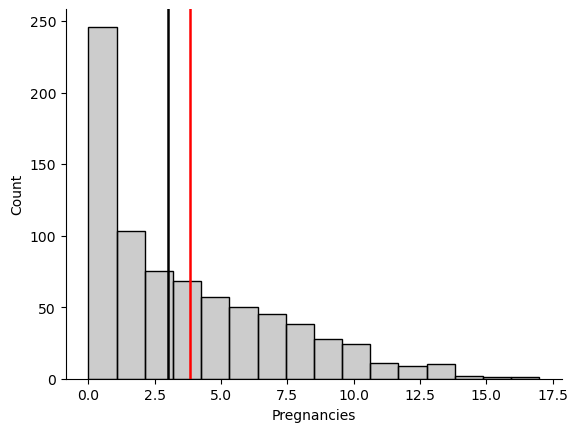

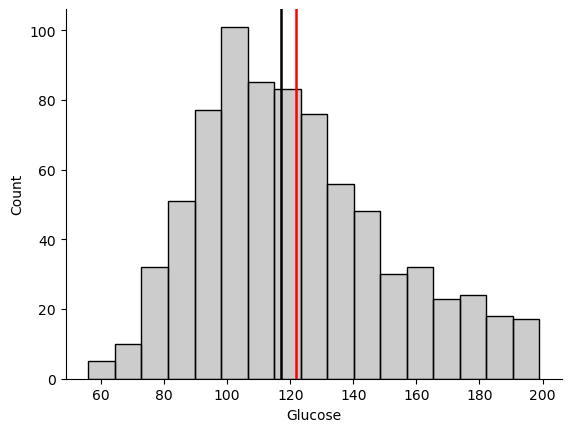

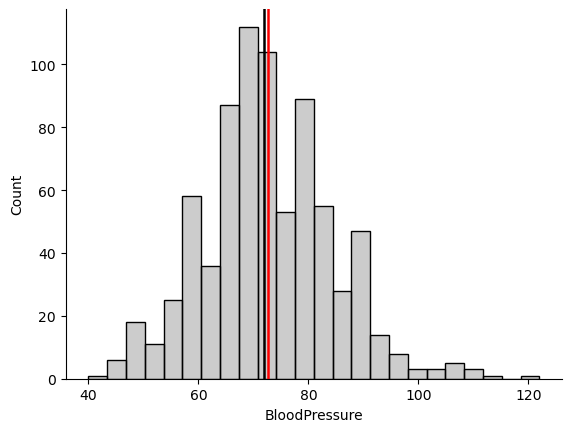

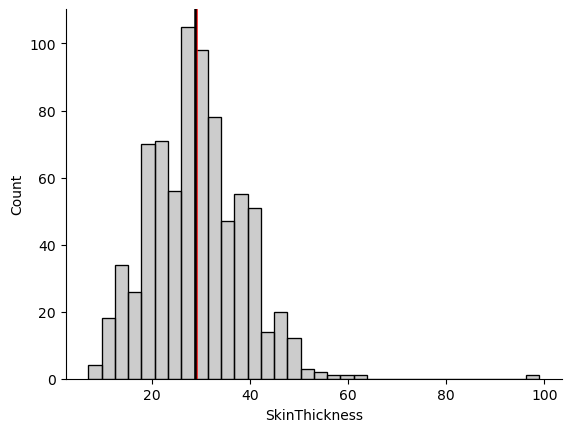

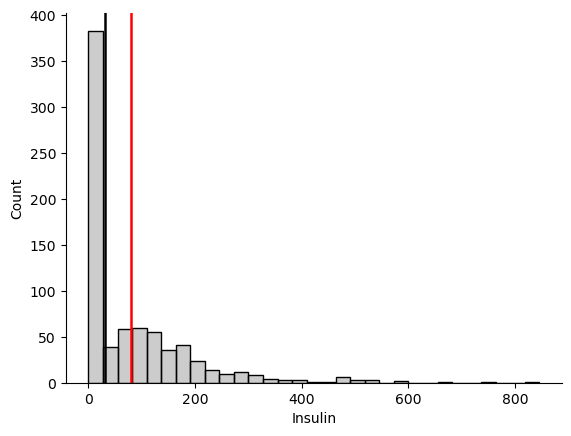

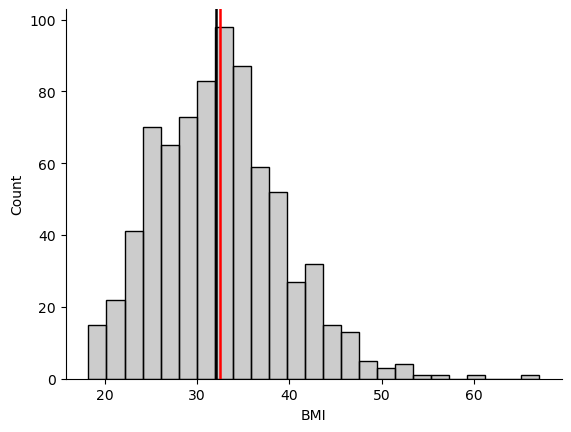

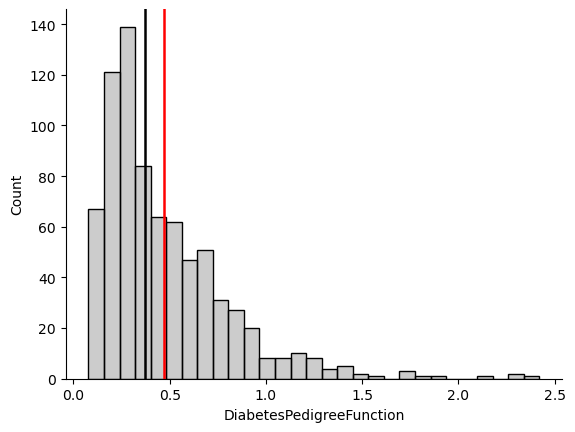

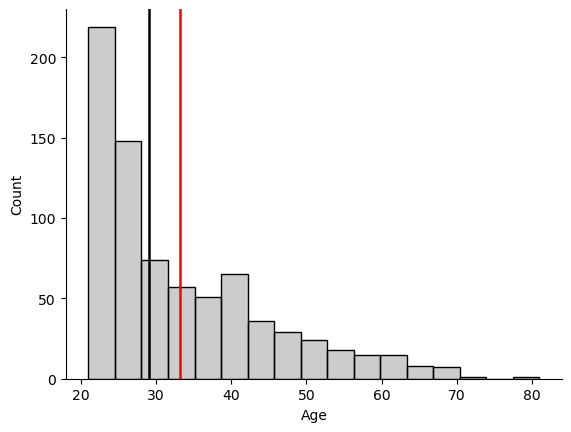

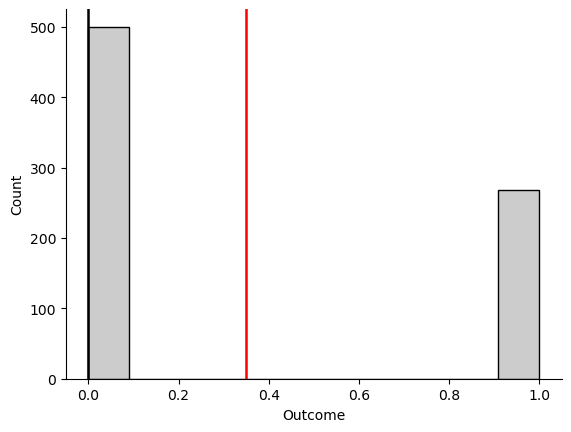

In [232]:
for col in diabetes_mice.columns:
    sns.histplot(x=col, data=diabetes_mice, alpha=.4, color='grey')
    plt.axvline(x=diabetes_mice[col].mean(), color='red', linewidth=1.8)
    plt.axvline(x=diabetes_mice[col].median(), color='black', linewidth=1.8)
    sns.despine()
    plt.show()

## additional columns

In [233]:
conditions_bmi = [
    (diabetes_mice['BMI'] >= 16.5) & (diabetes_mice['BMI'] < 18.5),
    (diabetes_mice['BMI'] >= 18.5) & (diabetes_mice['BMI'] < 25),
    (diabetes_mice['BMI'] >= 25) & (diabetes_mice['BMI'] < 30),
    diabetes_mice['BMI'] >= 30
]
categories_bmi = ['Underweight', 'Normal', 'Overweight', 'Obese']
diabetes_mice['bmiClassification'] = pd.Categorical(pd.np.select(conditions_bmi, categories_bmi), categories=categories_bmi)
print(diabetes_mice.loc[:, ['BMI', 'bmiClassification']].head())

conditions_age = [(diabetes_mice['Age']<=25),
                  (diabetes_mice['Age']>25) & (diabetes_mice['Age']<=45),
                  (diabetes_mice['Age']>45) & (diabetes_mice['Age']<=65),
                  diabetes_mice['Age']>65]
categories_age = ['Young', 'Adult', 'Older Adult', 'Senior']
diabetes_mice['AgeClassification'] = pd.Categorical(pd.np.select(conditions_age, categories_age), categories=categories_age)
print(diabetes_mice.loc[:, ['Age', 'AgeClassification']].head())

    BMI bmiClassification
0  33.6             Obese
1  26.6        Overweight
2  23.3            Normal
3  28.1        Overweight
4  43.1             Obese
    Age AgeClassification
0  50.0       Older Adult
1  31.0             Adult
2  32.0             Adult
3  21.0             Young
4  33.0             Adult


C:\Users\8\AppData\Local\Temp\ipykernel_3556\1145672168.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  diabetes_mice['bmiClassification'] = pd.Categorical(pd.np.select(conditions_bmi, categories_bmi), categories=categories_bmi)
C:\Users\8\AppData\Local\Temp\ipykernel_3556\1145672168.py:16: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  diabetes_mice['AgeClassification'] = pd.Categorical(pd.np.select(conditions_age, categories_age), categories=categories_age)


## Total And Groups

In [234]:
# Totals and groups:
# 1- total diabetes:
print(diabetes_mice['Outcome'].value_counts())
print(diabetes_mice['Outcome'].value_counts(normalize=True))
# total 268 females with diabetes of 35%
print('#' * 50)

# 2- bmi groups all:
print(diabetes_mice['bmiClassification'].value_counts())
print(diabetes_mice['bmiClassification'].value_counts(normalize=True))
# total 482 obese females with 63%
print('#' * 50)

# 3- bmi groups diabetes:
print(with_diabetes['bmiClassification'].value_counts())
print(with_diabetes['bmiClassification'].value_counts(normalize=True))
# total 261 obese females with diabetes of 52%
print('#' * 50)

# 4- age groups all:
print(diabetes_mice['AgeClassification'].value_counts())
print(diabetes_mice['AgeClassification'].value_counts(normalize=True))
# total young and adults of 383 and 267 with 35% and 50% respectively
print('#' * 50)

# 5- age groups diabetes
print(with_diabetes['AgeClassification'].value_counts()) 
print(with_diabetes['AgeClassification'].value_counts(normalize=True))
# total young and adults with diabetes of 222 and 218 with 44% and 44% respectively.
print('#' * 50)


# 6- average insulin by Outcome:
print(diabetes_mice.groupby('Outcome')['Insulin'].mean())
# average insulin for females with diabetes is  100.335 compared to females without diabetes 68.792 with an increase of 45.85%
print('#' * 50)


# 7- average glucose by Outcome:
print(diabetes_mice.groupby('Outcome')['Glucose'].mean())
# average glucose for females with diabetes is 142.26 compared to females without diabetes 110.71 with an increase of 28.5%
print('#' * 50)


# 8- average bmi by outcome:
print(diabetes_mice.groupby('Outcome')['BMI'].mean())
# average bmi for females with diabetes is 35.40 compared to females without diabetes 30.85 with an increase of 14.75%
print('#' * 50)


# 9- average blood pressure by outcome:
print(diabetes_mice.groupby('Outcome')['BloodPressure'].mean())
# average blood pressure for females with diabetes is 75.55 compared to females without diabetes 71.06 with an increase of 6.32% 
print('#' * 50)


# 10- average age by outcome:
print(diabetes_mice.groupby('Outcome')['Age'].mean())
# average age for females with diabetes 37.07 compared to females without diabetes 31.19 with an increase of 18.85%
print('#' * 50)

0.0    500
1.0    268
Name: Outcome, dtype: int64
0.0    0.651042
1.0    0.348958
Name: Outcome, dtype: float64
##################################################
Obese          482
Overweight     180
Normal         102
Underweight      4
Name: bmiClassification, dtype: int64
Obese          0.627604
Overweight     0.234375
Normal         0.132812
Underweight    0.005208
Name: bmiClassification, dtype: float64
##################################################
Obese          261
Overweight     140
Normal          95
Underweight      4
Name: bmiClassification, dtype: int64
Obese          0.522
Overweight     0.280
Normal         0.190
Underweight    0.008
Name: bmiClassification, dtype: float64
##################################################
Adult          383
Young          267
Older Adult    105
Senior          13
Name: AgeClassification, dtype: int64
Adult          0.498698
Young          0.347656
Older Adult    0.136719
Senior         0.016927
Name: AgeClassification, dtype: float

## Visualizations and correlation

C:\Users\8\AppData\Local\Temp\ipykernel_3556\4273633289.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(diabetes_mice.corr(), annot=True)


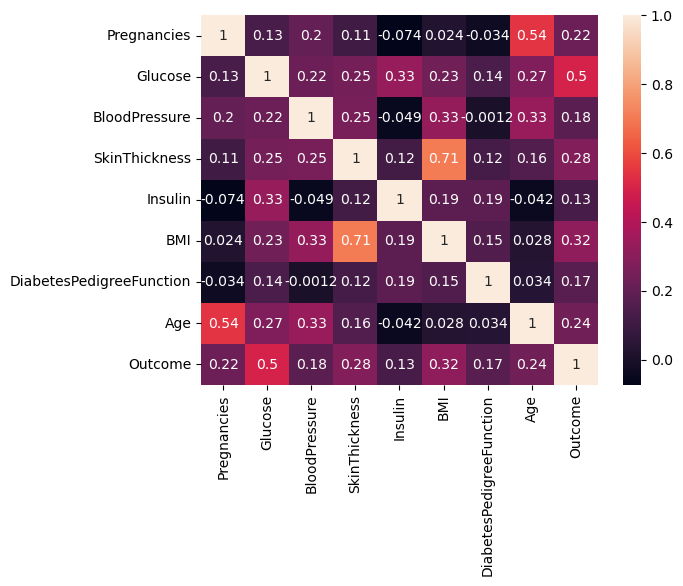

C:\Users\8\AppData\Local\Temp\ipykernel_3556\4273633289.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(with_diabetes.corr(), annot=True)


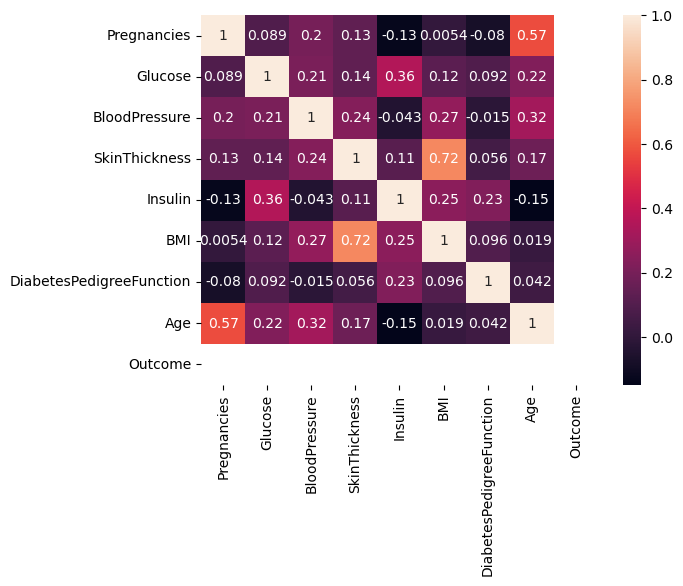

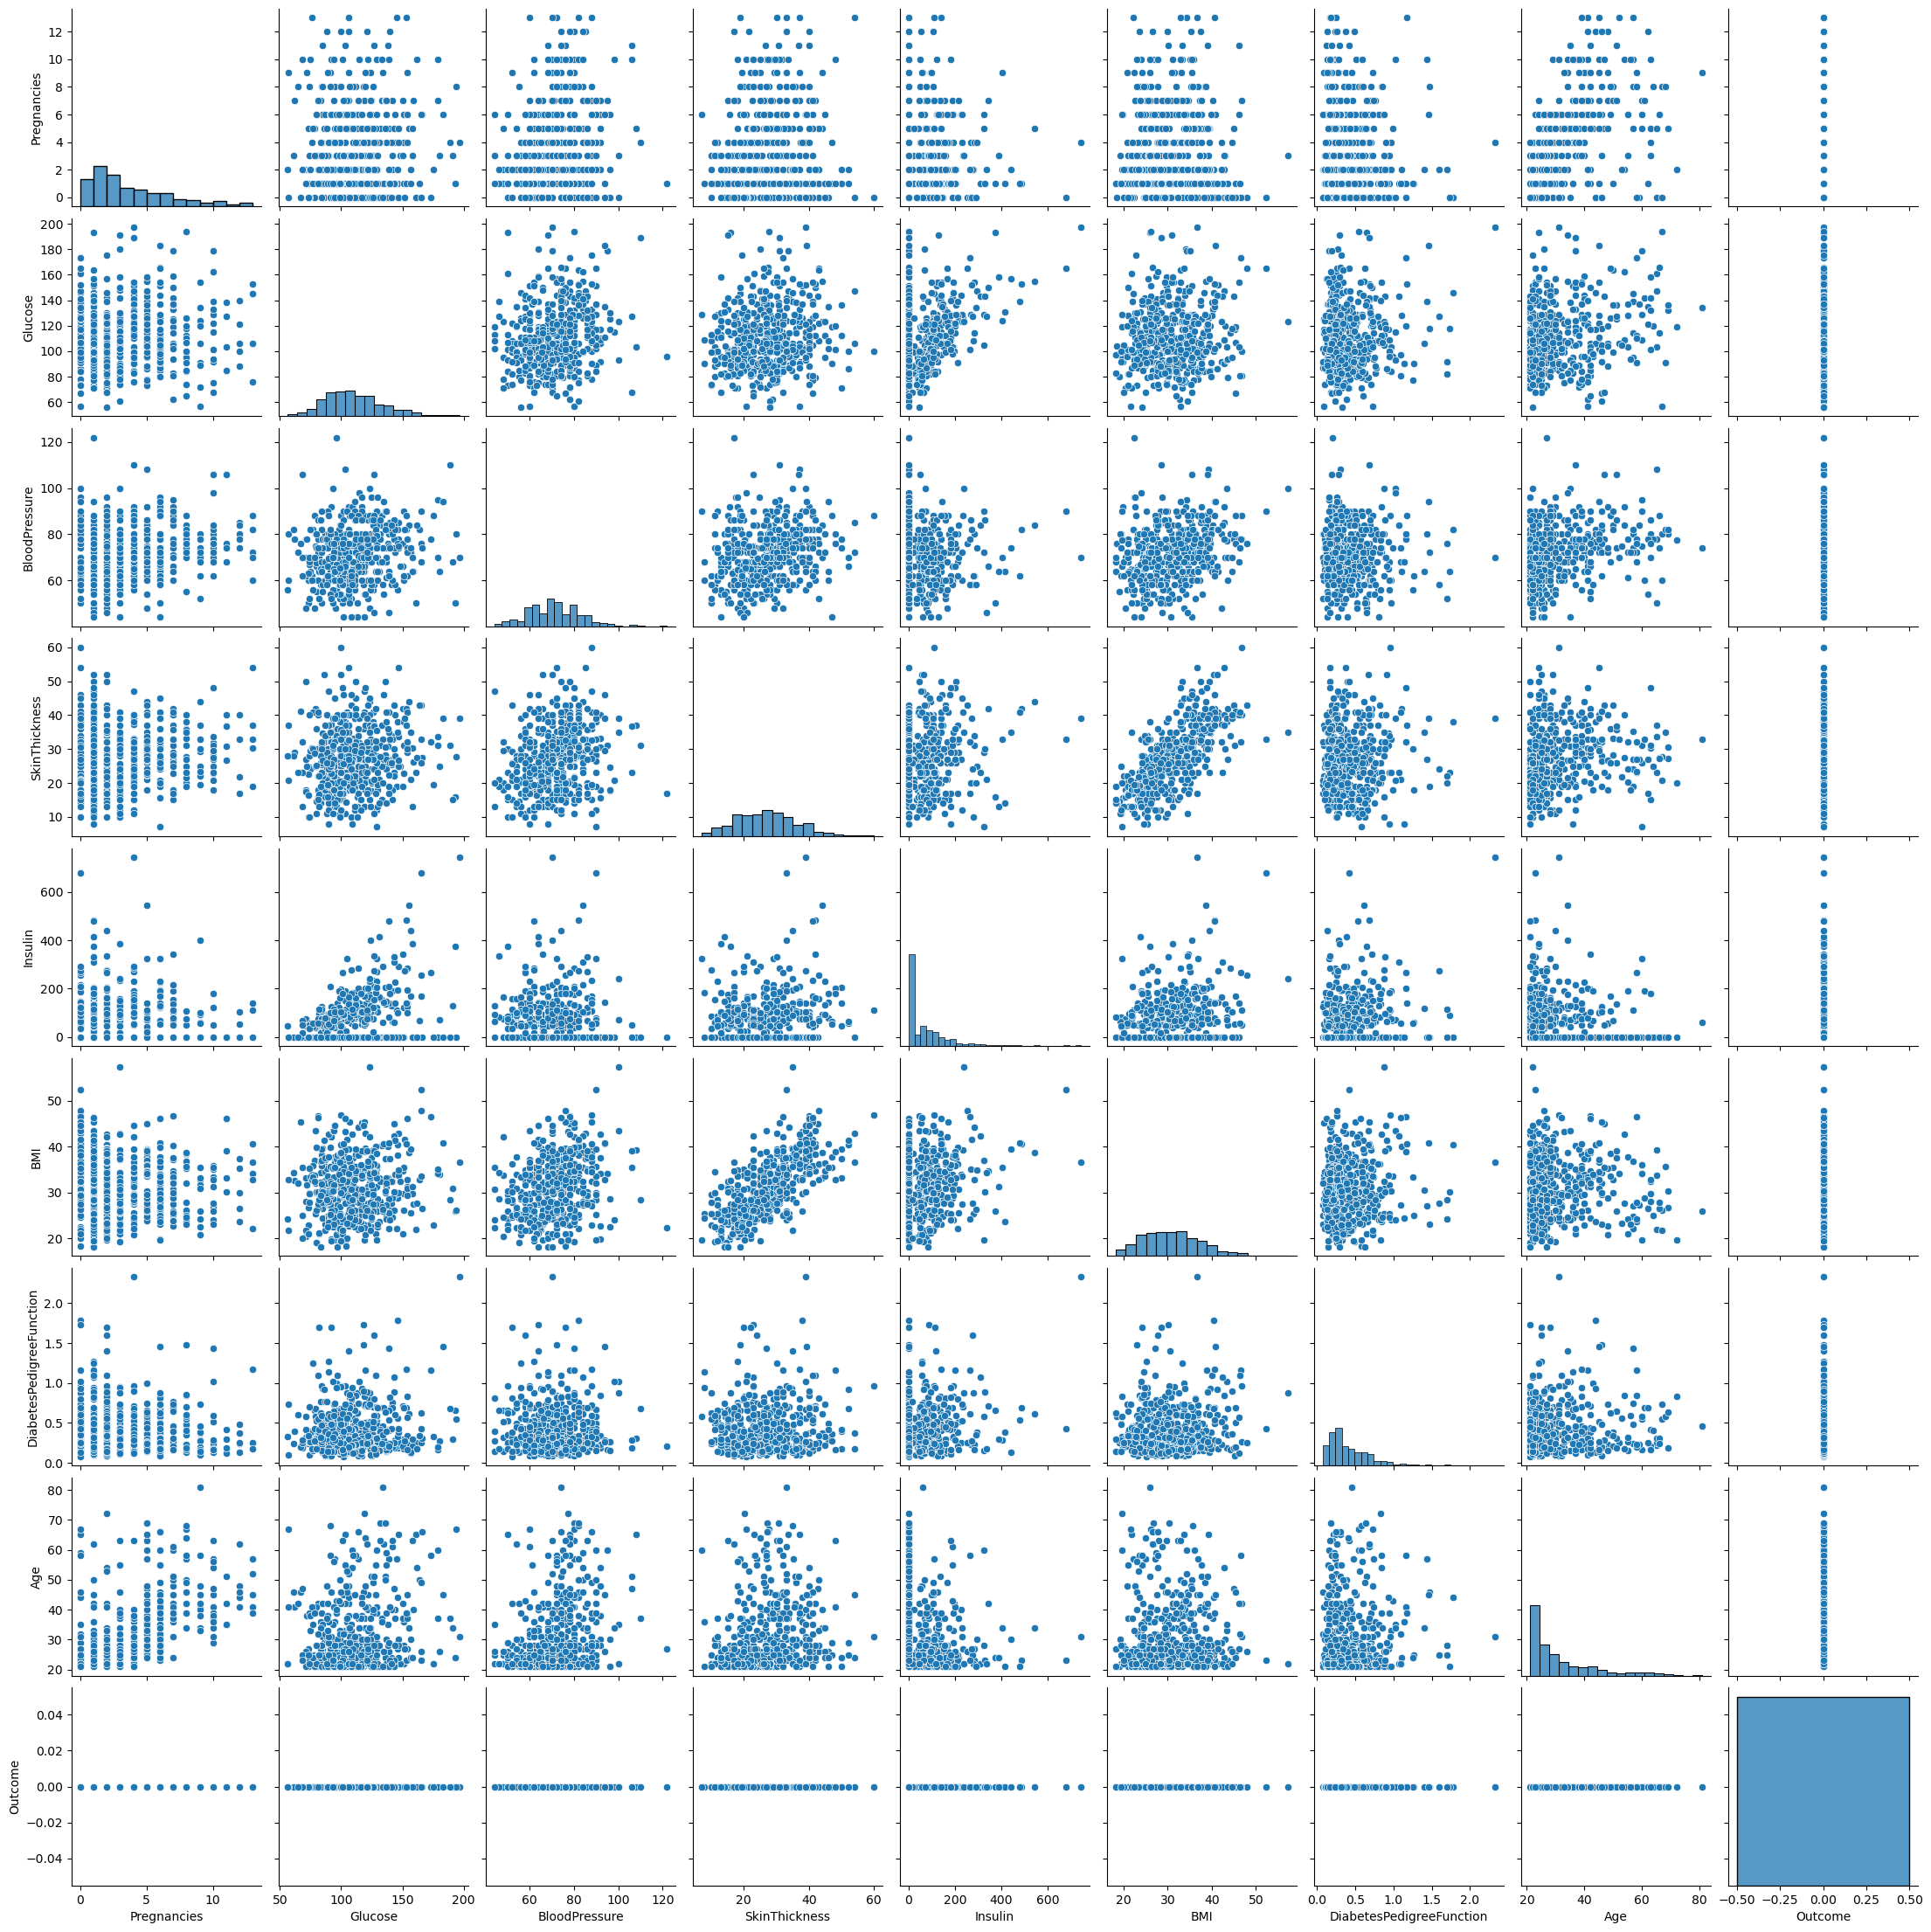

In [235]:
sns.heatmap(diabetes_mice.corr(), annot=True)
plt.show()
sns.heatmap(with_diabetes.corr(), annot=True)
plt.show()
sns.pairplot(with_diabetes)
plt.show()

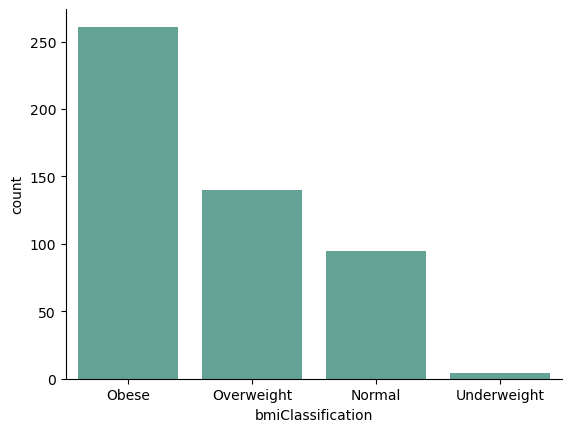

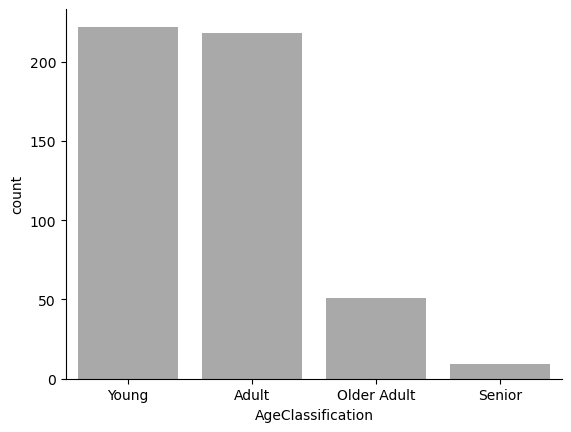

In [240]:
sns.countplot(x='bmiClassification', data=with_diabetes, color='#59AC9B', order=['Obese', 'Overweight', 'Normal', 'Underweight'])
sns.despine()
plt.show()
sns.countplot(x='AgeClassification', data=with_diabetes, color='darkgrey')
sns.despine()
plt.show()

In [237]:
x = diabetes_mice[[ 'Glucose', 'BloodPressure', 'Insulin','BMI', 'DiabetesPedigreeFunction']] 
y = diabetes_mice['Outcome']
# it gave me the best accuracy with these variables
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=257)
logisticRegression = LogisticRegression().fit(x_train, y_train)
y_pred = logisticRegression.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]
print(accuracy)
print(conf_mat)
print(TN, FP, FN, TP)

0.7662337662337663
[[132  21]
 [ 33  45]]
132 21 33 45


In [241]:
diabetes_mice.to_csv('diabetes_mice.csv')